<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>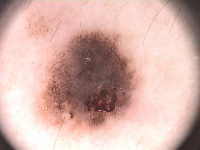</td><td>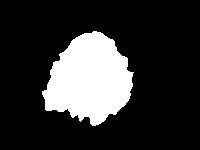</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
# Блокнот тестировался на Kaggle, dataset был предварительно загружен во вкладке data.
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [2]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-07-17 17:23:17--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-07-17 17:23:18--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1a6dc2b2084474b9e4fc66843a.dl.dropboxusercontent.com/cd/0/inline/BpQZXXgWh2COyWemVyU0ceOwmirpaCyXa9aTX05MfJRQPN9uoP5LTX9nfK2ibvDBCF4PuymX7ORh9JfDiF6IX2L7-Lbb03NXuhMcVVrrbg9AfYFbstdlvsrSOdlNq_7wgXCZAKfKTu_qL0RxzDMyQSQlk5OMOMOuMilQUDDb89ivzg/file# [following]
--2022-07-17 17:23:18--  https://uc1a6dc2b2084474b9e4fc66843a.dl.dropboxusercontent.com/cd/0/inline/BpQZXXgWh2COyWemVyU0ceOwmirpaCyXa9aTX05MfJRQPN9uoP5LTX9nfK2ibv

In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [4]:
import pickle
#
images = []
lesions = []
from skimage.io import imread
import os
from pathlib import Path
root = '../input/d/nurkhanlaiyk/ph2dataset/PH2Dataset'

for d in Path(root+'/PH2 Dataset images').iterdir():
    for imd in Path(d).iterdir():
        if str(imd).endswith('_Dermoscopic_Image'):
            images.append(imread(next(imd.iterdir())))
        if str(imd).endswith('_lesion'):
            lesions.append(imread(next(imd.iterdir())))

In [5]:
print(len(lesions))

200


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
print(len(lesions))

Loaded 200 images
200


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

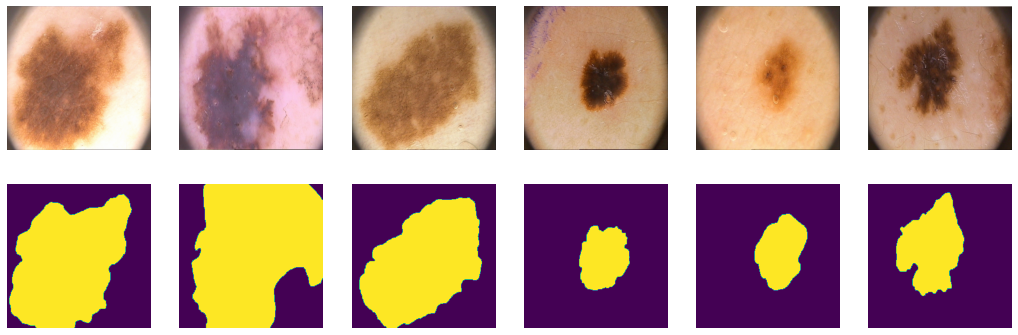

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [9]:
import torch

seed = 19841983
torch.manual_seed(seed)
np.random.seed(seed)

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 5
batch_size_test = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_vl = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size_test, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size_test, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

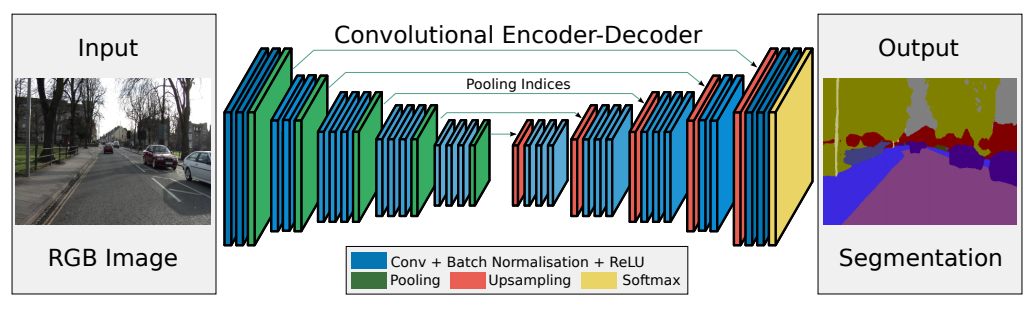

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
from torchvision import datasets, models, transforms

# Посмотрим, как устроена VGG16 с BatchNorm
models.vgg16_bn()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [14]:
# Вспомогательный класс. Реализация синего слоя с картинки выше

class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding):
        super(conv2DBatchNormRelu, self).__init__()

        self.unit = nn.Sequential(
            nn.Conv2d(int(in_channels), int(n_filters), kernel_size=k_size, padding=padding, stride=stride),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.unit(inputs)

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

#         self.enc_conv4 = nn.Sequential(
#             conv2DBatchNormRelu(512, 512, 3, 1, 1),
#             conv2DBatchNormRelu(512, 512, 3, 1, 1),
#             conv2DBatchNormRelu(512, 512, 3, 1, 1),           
#         )
#         self.pool4 = nn.MaxPool2d(2, 2, return_indices=True) # 16 -> 8

        # bottleneck
        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        # decoder (upsampling)

#         self.upsample4 = nn.MaxUnpool2d(2, 2) # 8 -> 16
#         self.dec_conv4 = nn.Sequential(
#             conv2DBatchNormRelu(512, 512, 3, 1, 1),
#             conv2DBatchNormRelu(512, 512, 3, 1, 1),
#             conv2DBatchNormRelu(512, 512, 3, 1, 1)
#         )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True) # в последнем слое активация не нужна
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))        
        #e4, ind4 = self.pool4(self.enc_conv4(e3))

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        #d4 = self.dec_conv4(self.upsample4(bottle_neck, ind4)) #e4
        d3 = self.dec_conv3(self.upsample3(bottle_neck, ind3))
        d2 = self.dec_conv2(self.upsample2(d3, ind2))
        d1 = self.dec_conv1(self.upsample1(d2, ind1))
        d0 = self.dec_conv0(self.upsample0(d1, ind0))

        # no activation
        return d0

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [16]:
# аргументы поменял местами в соотвтетвии с документацией библиотечных лоссов
def bce_loss(y_pred, y_real):
    loss = y_pred - y_real*y_pred + (1 + torch.exp(-y_pred)).log()
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [17]:
def train(model, optimizer, scheduler, loss_fn, score_fn, epochs, data_tr, data_vl):

    torch.cuda.empty_cache()

    losses_train = []
    losses_val = []
    scores_train = []
    scores_val = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)            

            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass

            loss.backward()  # backward-pass
            optimizer.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        print('train_loss: %f' % avg_loss)
        losses_train.append(avg_loss)

        # train score
        avg_score_train = score_fn(model, iou_pytorch, data_tr)
        scores_train.append(avg_score_train)

        # val loss
        avg_loss_val = 0
        model.eval()  # testing mode
        for X_val, Y_val in data_vl:
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()# detach and put into cpu

                loss = loss_fn(Y_hat, Y_val) # forward-pass
                avg_loss_val += loss / len(data_vl)

        toc = time()
        print('val_loss: %f' % avg_loss_val)
        losses_val.append(avg_loss_val)

        # val score
        avg_score_val = score_fn(model, iou_pytorch, data_vl)
        scores_val.append(avg_score_val)

        if scheduler:
            scheduler.step(avg_score_val)

        torch.cuda.empty_cache()
          
    return (losses_train, losses_val, scores_train, scores_val)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [18]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        with torch.no_grad():
            Y_pred = model(X_batch.to(device))
            # Выходы модели не приведены к 0 и 1, в отличие от масок
            # Буду приравнивать выходы больше порога к 1, а меньше или равные - к 0            
            # Порог пусть будет 0.1
            Y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.1)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [19]:
train_flag = True

def plot_results(rslts, ttl=''):
    plt.figure(figsize=(15, 9))
    plt.plot(rslts[0], label="train_loss")
    plt.plot(rslts[1], label="val_loss")
    plt.plot(rslts[2], label="train_score")
    plt.plot(rslts[3], label="val_score")

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(ttl)
    plt.show()
    
def train_and_save(mdl, loss, name):
    
    EPOCHS = 150

    model = mdl().to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00100, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.8)
    results = train(model, optimizer, scheduler, loss, score_model, EPOCHS, data_tr, data_vl)
    
    with open(f'{name}.model', 'wb') as model_file:
        #print('{name}.model')
        pickle.dump(model, model_file)
    with open(f'{name}.results', 'wb') as results_file:
        pickle.dump(results, results_file)
        
    return model, results

def load_results(name):  #./segnet_bce.model
    with open(f'./{name}.model', 'rb') as model_file: #../input/segnet1/{name}.model
        model = pickle.load(model_file)
    with open(f'./{name}.results', 'rb') as results_file:
        results = pickle.load(results_file)
    return model, results

def train_or_load(mdl, loss, name, train = True):
    return train_and_save(mdl, loss, name) if (train_flag and train) else load_results(name)

In [20]:
model_bce_loss, results_model_bce_loss = train_or_load(SegNet, bce_loss, 'segnet_bce')

* Epoch 1/150
train_loss: nan
val_loss: nan


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


* Epoch 2/150
train_loss: nan
val_loss: nan
* Epoch 3/150
train_loss: nan
val_loss: nan
* Epoch 4/150
train_loss: nan
val_loss: nan
* Epoch 5/150
train_loss: nan
val_loss: nan
* Epoch 6/150
train_loss: nan
val_loss: nan
* Epoch 7/150
train_loss: nan
val_loss: nan
* Epoch 8/150
train_loss: nan
val_loss: nan
* Epoch 9/150
train_loss: nan
val_loss: nan
* Epoch 10/150
train_loss: nan
val_loss: nan
* Epoch 11/150
train_loss: nan
val_loss: nan
* Epoch 12/150
train_loss: nan
val_loss: nan
* Epoch 13/150
train_loss: nan
val_loss: nan
* Epoch 14/150
train_loss: nan
val_loss: nan
* Epoch 15/150
train_loss: nan
val_loss: nan
* Epoch 16/150
train_loss: nan
val_loss: nan
* Epoch 17/150
train_loss: nan
val_loss: nan
* Epoch 18/150
train_loss: nan
val_loss: nan
* Epoch 19/150
train_loss: nan
val_loss: nan
* Epoch 20/150
train_loss: nan
val_loss: nan
* Epoch 21/150
train_loss: nan
val_loss: nan
* Epoch 22/150
train_loss: nan
val_loss: nan
* Epoch 23/150
train_loss: nan
val_loss: nan
* Epoch 24/150
tra

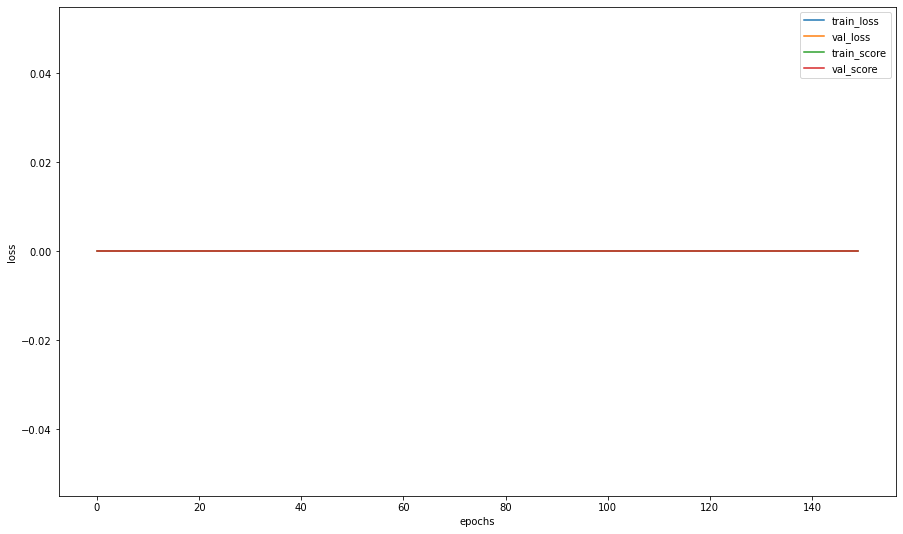

In [21]:
plot_results(results_model_bce_loss)

In [22]:
# Проверим скор обученной модели на валидационной и тестовой выборках
print (score_model(model_bce_loss, iou_pytorch, data_vl), score_model(model_bce_loss, iou_pytorch, data_ts))

0.0 0.0


In [23]:
def plot_items(model, loader, cnt):

    model.eval()
    X, Y = next(iter(loader))
    X = X.to(device)
    Y_pred = model(X)

    p = Y_pred.detach().cpu()
    p_post = torch.ones_like(p) * (p > 0.1)
    y = Y
    
    plt.figure(figsize=(15, 10))
    for i in range(cnt):
        plt.subplot(3, cnt, i+1+cnt*0)
        plt.imshow(np.rollaxis(p[i,0].numpy(), 0), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        
        plt.subplot(3, cnt, i+1+cnt*1)
        plt.imshow(np.rollaxis(p_post[i,0].numpy(), 0), cmap='gray')
        plt.title('Post-processing')
        plt.axis('off')

        plt.subplot(3, cnt, i+1+cnt*2)
        plt.imshow(np.rollaxis(y[i,0].numpy(), 0), cmap='gray')
        plt.title('Real')
        plt.axis('off')

/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/conda/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


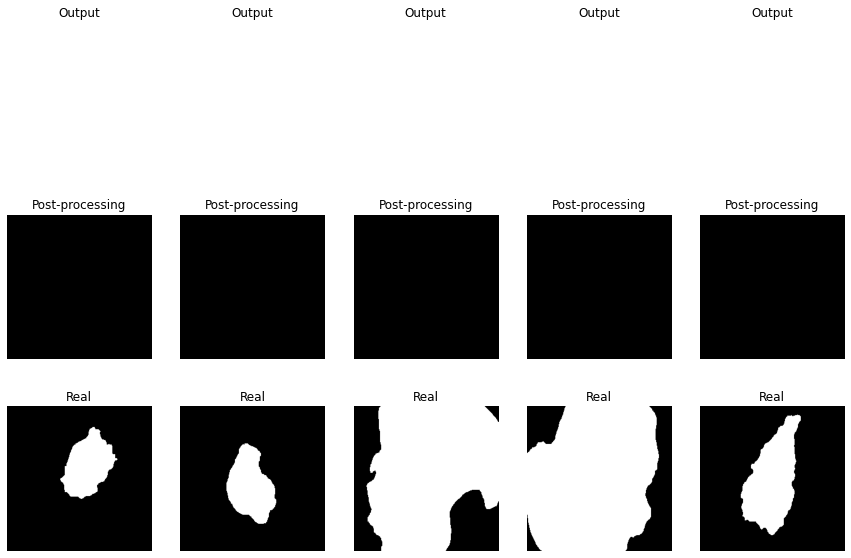

In [24]:
# На тестовой выборке сравним выходы модели c масками из обучающей выборки

plot_items(model_bce_loss, data_ts, 5)

Ответьте себе на вопрос: не переобучается ли моя модель?

Судя по нарастающему примерно с 100 эпохи разрыву в скоре, а также по нарастающему с 110 этопи расхождению между функцией потерь для обучающей и для валидационной выборки - да, модель несколько переобучилась. Но она и должна, обучающая выборка слишком мала, её легко запомнить для модели таких размеров.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [25]:
def dice_loss(y_pred, y_real):

    smooth = 1e-8
    outputs = y_pred.sigmoid().squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = y_real.squeeze(1)    

    i = (outputs * labels).sum()
    s = (outputs + labels).sum()
    r = 1 - ((2. * i + smooth) / (s + smooth))#/(256*256)
    
    return r 

Проводим тестирование:

In [26]:
model_dice_loss, results_model_dice_loss = train_or_load(SegNet, dice_loss, 'segnet_dice')

* Epoch 1/150
train_loss: 0.569034
val_loss: 0.560394
* Epoch 2/150
train_loss: 0.509419
val_loss: 0.460439
* Epoch 3/150
train_loss: 0.476531
val_loss: 0.425784
* Epoch 4/150
train_loss: 0.452195
val_loss: 0.395075
* Epoch 5/150
train_loss: 0.456877
val_loss: 0.395693
* Epoch 6/150
train_loss: 0.434378
val_loss: 0.391346
* Epoch 7/150
train_loss: 0.443028
val_loss: 0.369614
* Epoch 8/150
train_loss: 0.436850
val_loss: 0.387019
* Epoch 9/150
train_loss: 0.429348
val_loss: 0.378327
* Epoch 10/150
train_loss: 0.423322
val_loss: 0.360924
* Epoch 11/150
train_loss: 0.405118
val_loss: 0.355599
* Epoch 12/150
train_loss: 0.404122
val_loss: 0.369888
* Epoch 13/150
train_loss: 0.385155
val_loss: 0.345380
* Epoch 14/150
train_loss: 0.400842
val_loss: 0.350294
* Epoch 15/150
train_loss: 0.401670
val_loss: 0.349877
* Epoch 16/150
train_loss: 0.381838
val_loss: 0.333375
* Epoch 17/150
train_loss: 0.391282
val_loss: 0.361432
* Epoch 18/150
train_loss: 0.370960
val_loss: 0.314231
* Epoch 19/150
trai

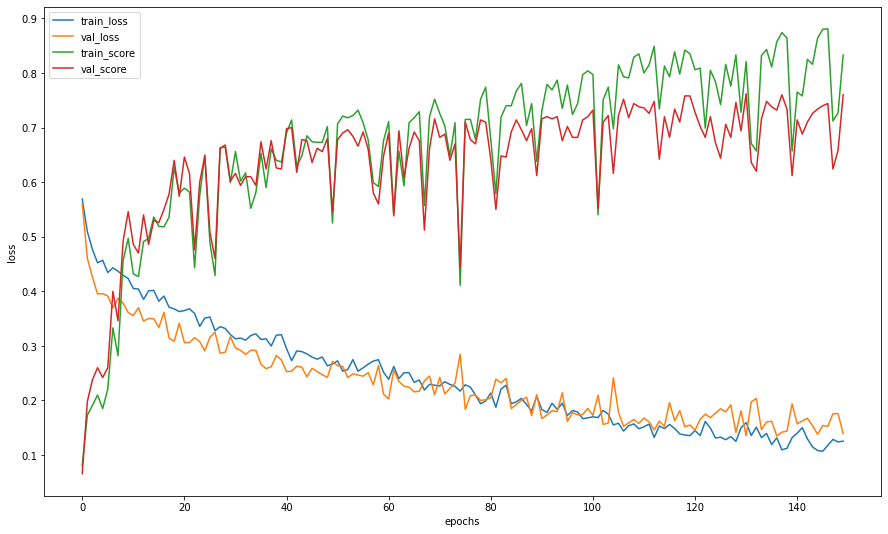

In [27]:
plot_results(results_model_dice_loss)

In [28]:
print (score_model(model_dice_loss, iou_pytorch, data_vl), score_model(model_dice_loss, iou_pytorch, data_ts))

0.7599999904632568 0.6939999759197235


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [29]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y = y_pred.sigmoid()+eps
    loss = -((1-y)**gamma*y_real*y.log()+(1-y_real)*(1-y).log())
    
    return loss.mean()

In [30]:
model_focal_loss, results_model_focal_loss = train_or_load(SegNet, focal_loss, 'segnet_focal')

* Epoch 1/150
train_loss: 0.565153
val_loss: 0.533725
* Epoch 2/150
train_loss: nan
val_loss: nan
* Epoch 3/150
train_loss: nan
val_loss: nan
* Epoch 4/150
train_loss: nan
val_loss: nan
* Epoch 5/150
train_loss: nan
val_loss: nan
* Epoch 6/150
train_loss: nan
val_loss: nan
* Epoch 7/150
train_loss: nan
val_loss: nan
* Epoch 8/150
train_loss: nan
val_loss: nan
* Epoch 9/150
train_loss: nan
val_loss: nan
* Epoch 10/150
train_loss: nan
val_loss: nan
* Epoch 11/150
train_loss: nan
val_loss: nan
* Epoch 12/150
train_loss: nan
val_loss: nan
* Epoch 13/150
train_loss: nan
val_loss: nan
* Epoch 14/150
train_loss: nan
val_loss: nan
* Epoch 15/150
train_loss: nan
val_loss: nan
* Epoch 16/150
train_loss: nan
val_loss: nan
* Epoch 17/150
train_loss: nan
val_loss: nan
* Epoch 18/150
train_loss: nan
val_loss: nan
* Epoch 19/150
train_loss: nan
val_loss: nan
* Epoch 20/150
train_loss: nan
val_loss: nan
* Epoch 21/150
train_loss: nan
val_loss: nan
* Epoch 22/150
train_loss: nan
val_loss: nan
* Epoch 2

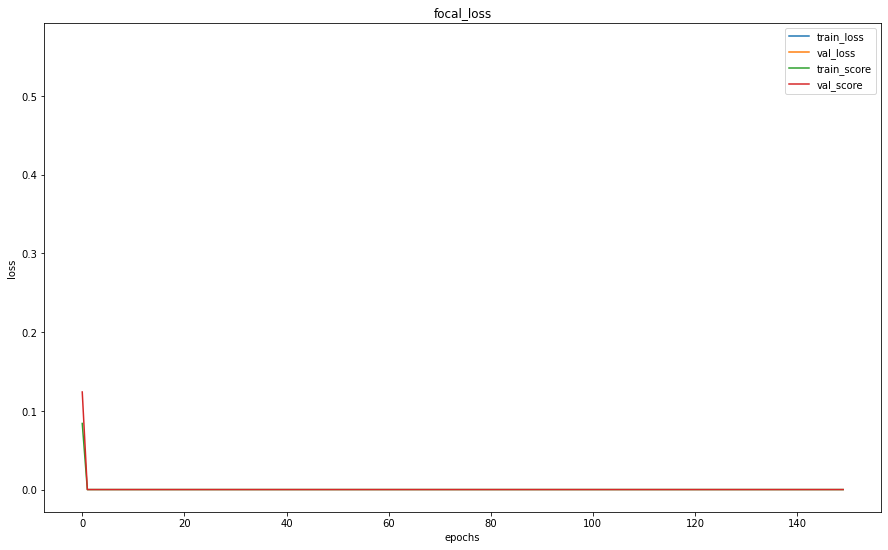

In [31]:
plot_results(results_model_focal_loss, 'focal_loss')

In [32]:
print (score_model(model_focal_loss, iou_pytorch, data_vl), score_model(model_focal_loss, iou_pytorch, data_ts))

0.0 0.0


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [33]:
def tversky_loss(y_pred, y_real, smooth=1e-8, alpha=0.3, beta=0.7):
    y_pred = y_pred.sigmoid().view(-1)
    y_real = y_real.view(-1)

    TP = (y_pred * y_real).sum() #True Positive
    FP = ((1-y_real) * y_pred).sum() #False Positive
    FN = (y_real * (1-y_pred)).sum() #False Negative

    return 1 - (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  

In [34]:
model_tversky_loss, results_model_tversky_loss = train_or_load(SegNet, tversky_loss, 'segnet_tversky')

* Epoch 1/150
train_loss: 0.493719
val_loss: 0.518598
* Epoch 2/150
train_loss: 0.392775
val_loss: 0.411083
* Epoch 3/150
train_loss: 0.386681
val_loss: 0.351890
* Epoch 4/150
train_loss: 0.354810
val_loss: 0.314925
* Epoch 5/150
train_loss: 0.365209
val_loss: 0.330217
* Epoch 6/150
train_loss: 0.357776
val_loss: 0.312934
* Epoch 7/150
train_loss: 0.349763
val_loss: 0.289255
* Epoch 8/150
train_loss: 0.339326
val_loss: 0.311775
* Epoch 9/150
train_loss: 0.356962
val_loss: 0.317138
* Epoch 10/150
train_loss: 0.337126
val_loss: 0.308214
* Epoch 11/150
train_loss: 0.354176
val_loss: 0.268452
* Epoch 12/150
train_loss: 0.340765
val_loss: 0.282143
* Epoch 13/150
train_loss: 0.341988
val_loss: 0.303765
* Epoch 14/150
train_loss: 0.323268
val_loss: 0.307716
* Epoch 15/150
train_loss: 0.333720
val_loss: 0.298324
* Epoch 16/150
train_loss: 0.312923
val_loss: 0.303221
* Epoch 17/150
train_loss: 0.323207
val_loss: 0.285665
* Epoch 18/150
train_loss: 0.303550
val_loss: 0.292978
* Epoch 19/150
trai

In [35]:
print (score_model(model_tversky_loss, iou_pytorch, data_vl), score_model(model_tversky_loss, iou_pytorch, data_ts))

0.7660000026226044 0.7199999690055847


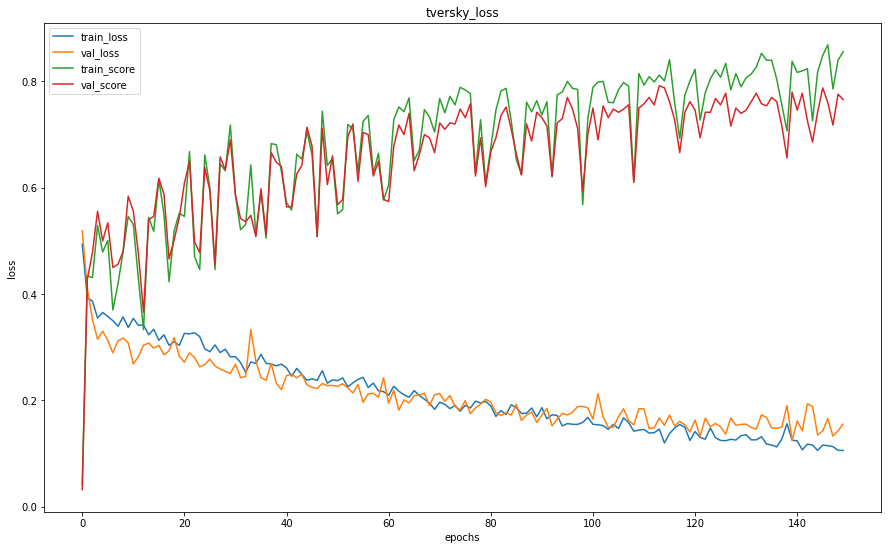

In [36]:
plot_results(results_model_tversky_loss, 'tversky_loss')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

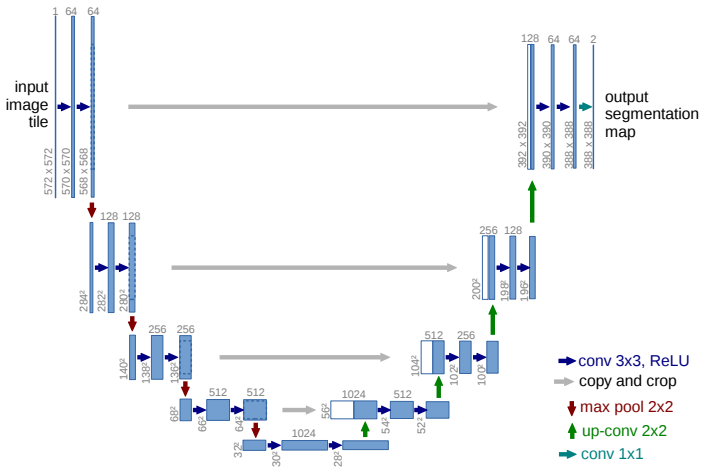

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [37]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512*2, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256*2, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128*2, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64*2, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))

        # no activation
        return d0

In [38]:
model_unet_bce_loss, results_model_unet_bce_loss = train_or_load(UNet, bce_loss, 'unet_bce')
model_unet_dice_loss, results_model_unet_dice_loss = train_or_load(UNet, dice_loss, 'unet_dice')
model_unet_focal_loss, results_model_unet_focal_loss = train_or_load(UNet, focal_loss, 'unet_focal')
model_unet_tversky_loss, results_model_unet_tversky_loss = train_or_load(UNet, tversky_loss, 'unet_tversky')

* Epoch 1/150
train_loss: 0.556864
val_loss: 0.600685
* Epoch 2/150
train_loss: 0.509343
val_loss: 0.504779
* Epoch 3/150
train_loss: 0.475643
val_loss: 0.460510
* Epoch 4/150
train_loss: 0.445013
val_loss: 0.470599
* Epoch 5/150
train_loss: 0.447592
val_loss: 0.617377
* Epoch 6/150
train_loss: 0.438849
val_loss: 0.424409
* Epoch 7/150
train_loss: 0.438364
val_loss: 0.394861
* Epoch 8/150
train_loss: 0.429573
val_loss: 0.411452
* Epoch 9/150
train_loss: 0.391830
val_loss: 0.419715
* Epoch 10/150
train_loss: 0.384809
val_loss: 0.358169
* Epoch 11/150
train_loss: 0.369639
val_loss: 0.352952
* Epoch 12/150
train_loss: 0.382795
val_loss: 0.373739
* Epoch 13/150
train_loss: 0.374046
val_loss: 0.354437
* Epoch 14/150
train_loss: 0.358996
val_loss: 0.374508
* Epoch 15/150
train_loss: 0.359203
val_loss: 0.358271
* Epoch 16/150
train_loss: 0.355064
val_loss: 0.350191
* Epoch 17/150
train_loss: 0.347550
val_loss: 0.327910
* Epoch 18/150
train_loss: 0.339640
val_loss: 0.322642
* Epoch 19/150
trai

In [39]:
print (score_model(model_unet_tversky_loss, iou_pytorch, data_vl), score_model(model_unet_tversky_loss, iou_pytorch, data_ts))

0.7420000433921814 0.7139999866485596


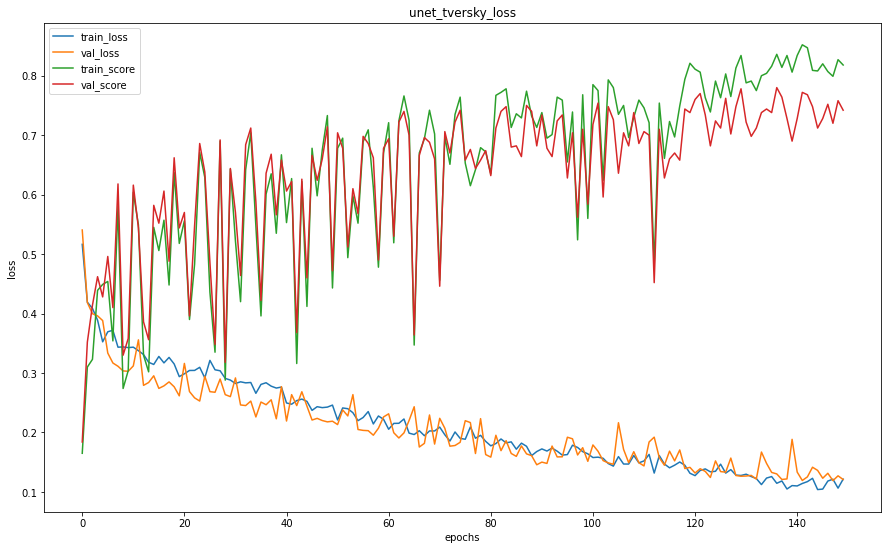

In [40]:
plot_results(results_model_unet_tversky_loss, 'unet_tversky_loss')

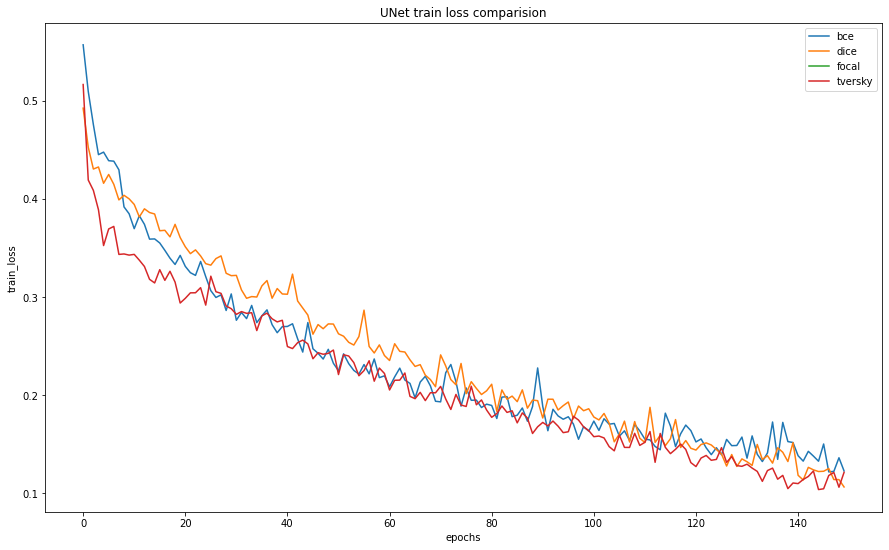

In [41]:
ind=0
plt.figure(figsize=(15, 9))
plt.plot(results_model_unet_bce_loss[ind], label="bce")
plt.plot(results_model_unet_dice_loss[ind], label="dice")
plt.plot(results_model_unet_focal_loss[ind], label="focal")
plt.plot(results_model_unet_tversky_loss[ind], label="tversky")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet train loss comparision")
plt.show()

focal_loss сходится быстрее и стабильнее всех.

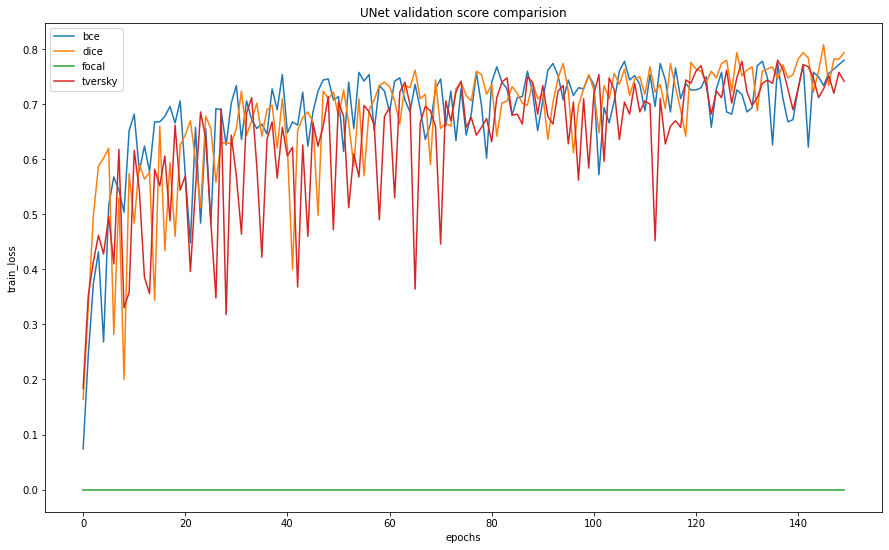

In [42]:
ind=3
plt.figure(figsize=(15, 9))
plt.plot(results_model_unet_bce_loss[ind], label="bce")
plt.plot(results_model_unet_dice_loss[ind], label="dice")
plt.plot(results_model_unet_focal_loss[ind], label="focal")
plt.plot(results_model_unet_tversky_loss[ind], label="tversky")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet validation score comparision")
plt.show()

Из графиков валидационных оценок сложно сделать вывод, какой вариант даёт более качественный прогноз. Слишком большие выбросы. Возможно, слишком мало данных и сеть перееобучается. На Симпсонах всё было более гладко и предсказуемо. Посмотрим на сглаженные значения.

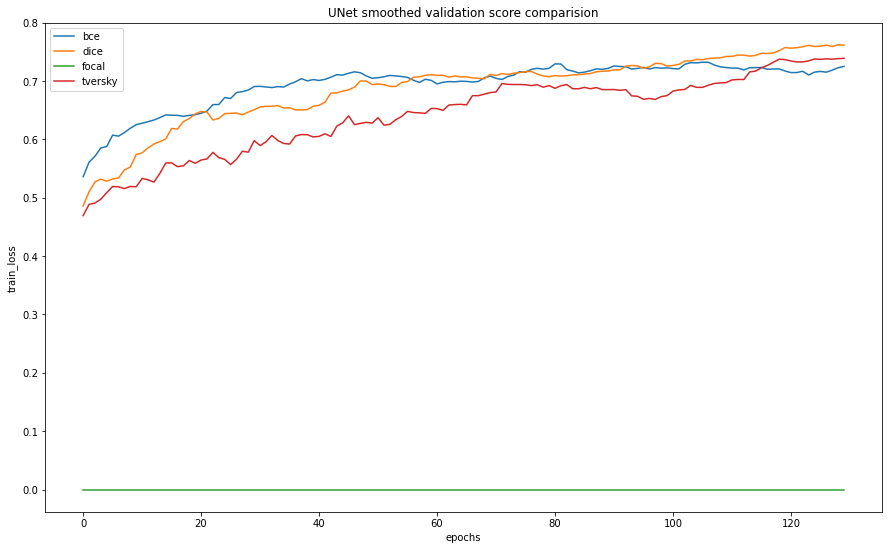

In [43]:
from statistics import mean 

ind=3
results = [
    [results_model_unet_bce_loss[ind], 'bce'],
    [results_model_unet_dice_loss[ind], 'dice'],
    [results_model_unet_focal_loss[ind], 'focal'],
    [results_model_unet_tversky_loss[ind], 'tversky']
]

plt.figure(figsize=(15, 9))
window=20
for r in results:
    v = [mean(r[0][x:x+window]) for x in range(150-window)]
    plt.plot(v, label=r[1])

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet smoothed validation score comparision")
plt.show()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [44]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv2DBatchNormRelu(3, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv2DBatchNormRelu(64, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv2DBatchNormRelu(128, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv2DBatchNormRelu(256, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1),
            conv2DBatchNormRelu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv2DBatchNormRelu(512, 1024, 1, 1, 0),
            conv2DBatchNormRelu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv2DBatchNormRelu(512*2, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
            conv2DBatchNormRelu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv2DBatchNormRelu(256*2, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
            conv2DBatchNormRelu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv2DBatchNormRelu(128*2, 64, 3, 1, 1),
            conv2DBatchNormRelu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv2DBatchNormRelu(64*2, 1, 3, 1, 1),
            conv2DBatchNormRelu(1, 1, 3, 1, 1),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder       
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, output_size=pre_e3.size()), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, output_size=pre_e2.size()), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, output_size=pre_e1.size()), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, output_size=pre_e0.size()), pre_e0], 1))

        # no activation
        return d0

In [45]:
model_unet2_bce_loss, results_model_unet2_bce_loss = train_or_load(UNet2, bce_loss, 'unet2_bce')
model_unet2_dice_loss, results_model_unet2_dice_loss = train_or_load(UNet2, dice_loss, 'unet2_dice')
model_unet2_focal_loss, results_model_unet2_focal_loss = train_or_load(UNet2, focal_loss, 'unet2_focal')
model_unet2_tversky_loss, results_model_unet2_tversky_loss = train_or_load(UNet2, tversky_loss, 'unet2_tversky')

* Epoch 1/150
train_loss: 0.566560
val_loss: 0.671249
* Epoch 2/150
train_loss: 0.507675
val_loss: 0.548989
* Epoch 3/150
train_loss: 0.504148
val_loss: 0.510278
* Epoch 4/150
train_loss: 0.458702
val_loss: 0.516503
* Epoch 5/150
train_loss: 0.435378
val_loss: 0.577181
* Epoch 6/150
train_loss: 0.426189
val_loss: 0.717772
* Epoch 7/150
train_loss: 0.394723
val_loss: 0.457934
* Epoch 8/150
train_loss: 0.399313
val_loss: 0.411344
* Epoch 9/150
train_loss: 0.397797
val_loss: 0.391134
* Epoch 10/150
train_loss: 0.402063
val_loss: 0.366696
* Epoch 11/150
train_loss: 0.391476
val_loss: 0.659950
* Epoch 12/150
train_loss: 0.409142
val_loss: 0.387285
* Epoch 13/150
train_loss: 0.397323
val_loss: 0.376402
* Epoch 14/150
train_loss: 0.389595
val_loss: 0.501047
* Epoch 15/150
train_loss: 0.388757
val_loss: 0.386228
* Epoch 16/150
train_loss: 0.367990
val_loss: 0.366539
* Epoch 17/150
train_loss: 0.361804
val_loss: 0.385492
* Epoch 18/150
train_loss: 0.357561
val_loss: 0.374803
* Epoch 19/150
trai

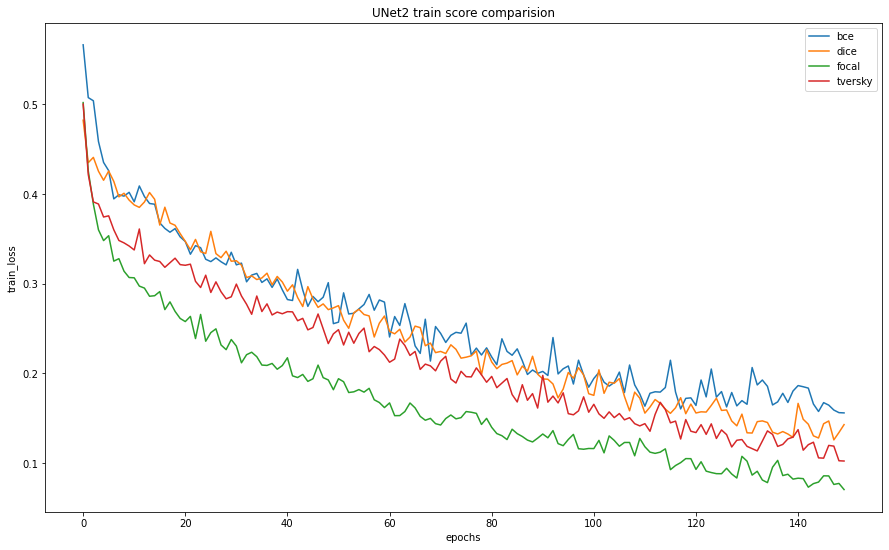

In [46]:
ind=0
plt.figure(figsize=(15, 9))
plt.plot(results_model_unet2_bce_loss[ind], label="bce")
plt.plot(results_model_unet2_dice_loss[ind], label="dice")
plt.plot(results_model_unet2_focal_loss[ind], label="focal")
plt.plot(results_model_unet2_tversky_loss[ind], label="tversky")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet2 train score comparision")
plt.show()

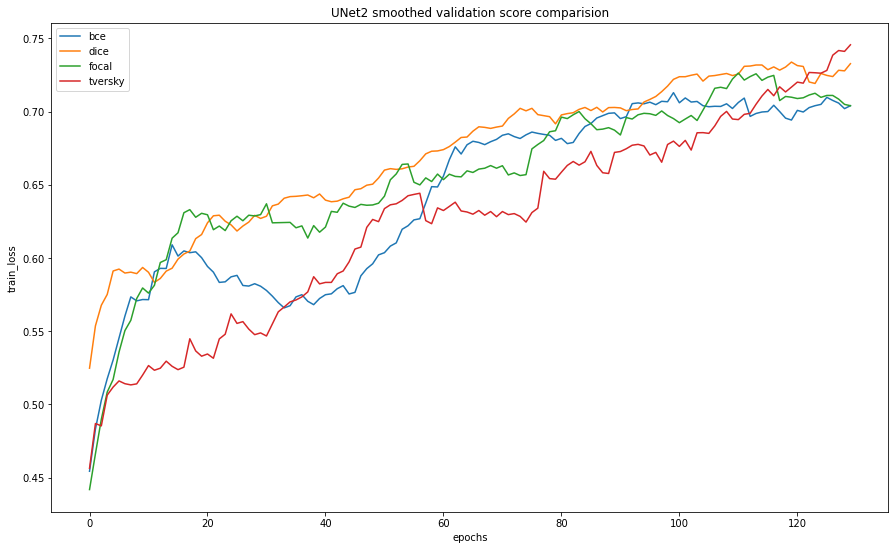

In [47]:
from statistics import mean 

ind=3
results = [
    [results_model_unet2_bce_loss[ind], 'bce'],
    [results_model_unet2_dice_loss[ind], 'dice'],
    [results_model_unet2_focal_loss[ind], 'focal'],
    [results_model_unet2_tversky_loss[ind], 'tversky']
]

plt.figure(figsize=(15, 9))
window=20
for r in results:
    v = [mean(r[0][x:x+window]) for x in range(150-window)]
    plt.plot(v, label=r[1])

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet2 smoothed validation score comparision")
plt.show()

Сделайте вывод какая из моделей лучше

### В целом по результатам обучения трёх разных моделей можно сделать вывод, что составленны они корректно (это была самая сложная часть работы), поскольку обучение происходит (с выходом на плато), скор растёт, лосс падает. Целью работы было найти наилучшую модель в смысле предсказания маски (на поиск ещё и по другим критериям, например по времени обучения, сил не осталось). 

### Неявная гипотеза заключалась в том, что модель со skip connections будет выдавать лучший результат. Давайте это проверим.

### Для сравнения моделей посмотрим на средний валидационный score в разрезе моделей и функций потерь (центрировано относительно значения 0.7). Поскольку score демонстрирует большой разброс, я возьму усреднённое значение по последним 50 эпохам из 150.


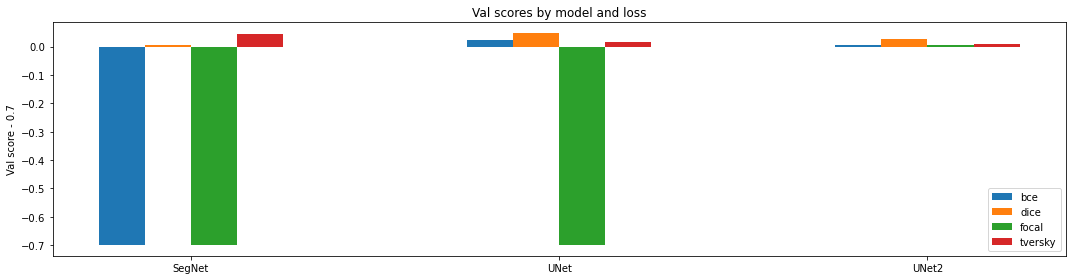

In [48]:
m = {}
for loss in ['bce','dice','focal','tversky']:
    m[loss] = {}
    for net in ['segnet','unet','unet2']:
        m[loss][net] = load_results(f'{net}_{loss}')

from statistics import mean 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

means = {loss:[mean(m[loss][x][1][3][100:])-0.7 for x in m[loss]] for loss in m}

ind = np.arange(3)
width = 0.5

fig, ax = plt.subplots()
ax.bar(ind - width/2 + width/8, means['bce'], width/4, label='bce')
ax.bar(ind - width/4 + width/8, means['dice'], width/4, label='dice')
ax.bar(ind + width/8, means['focal'], width/4, label='focal')
ax.bar(ind + width/4 + width/8, means['tversky'], width/4, label='tversky')

ax.set_ylabel('Val score - 0.7')
ax.set_title('Val scores by model and loss')
ax.set_xticks(ind)
ax.set_xticklabels(('SegNet', 'UNet', 'UNet2'))
ax.legend()

fig.tight_layout()
plt.show()

### Также интересно посмотреть на итоговый score на тестовой выборке (центрировано относительно значения 0.7). Здесь только одно значение, без усреднения.

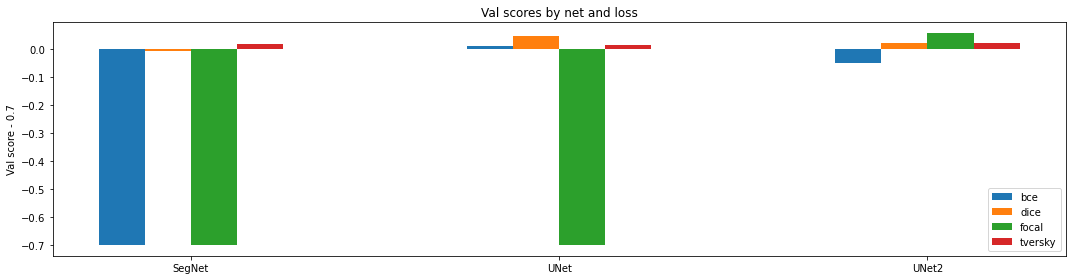

In [49]:
scores = {loss:[score_model(m[loss][x][0], iou_pytorch, data_ts)-0.7 for x in m[loss]] for loss in m}

ind = np.arange(3)
width = 0.5

fig, ax = plt.subplots()
ax.bar(ind - width/2 + width/8, scores['bce'], width/4, label='bce')
ax.bar(ind - width/4 + width/8, scores['dice'], width/4, label='dice')
ax.bar(ind + width/8, scores['focal'], width/4, label='focal')
ax.bar(ind + width/4 + width/8, scores['tversky'], width/4, label='tversky')

ax.set_ylabel('Val score - 0.7')
ax.set_title('Val scores by net and loss')
ax.set_xticks(ind)
ax.set_xticklabels(('SegNet', 'UNet', 'UNet2'))
ax.legend()

fig.tight_layout()
plt.show()

### Из диаграмм видно, что UNet c MaxPool2d/MaxUnpool2d является лучшей моделью. Это подтверждает основную гипотезу. При чём этот результат получается с использованием tversky_loss. Возможно это связанно с тем, что классы не сбалансированы (больше фона, чем родинок), а tversky_loss в использованном варианте сильнее штрафует за ложноотрицательные результаты (коеффициент beta при FN), то есть за то, что модель выдаёт фон, там где должна быть фигура (склоняется к чаще встречающемуся классу). 

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.